In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.chdir('./drive/MyDrive/AML/Coursework')

In [ ]:
#!unzip ./HMDB_simp.zip -d ./HMDB_simp

In [ ]:
#!pip install transformers torch torchvision datasets evaluate torchmetrics

# Data

## Create dataset

In [1]:
CATEGORY_INDEX = {
    "brush_hair": 0,
    "cartwheel": 1,
    "catch": 2,
    "chew": 3,
    "climb": 4,
    "climb_stairs": 5,
    "draw_sword": 6,
    "eat": 7,
    "fencing": 8,
    "flic_flac": 9,
    "golf": 10,
    "handstand": 11,
    "kiss": 12,
    "pick": 13,
    "pour": 14,
    "pullup": 15,
    "pushup": 16,
    "ride_bike": 17,
    "shoot_bow": 18,
    "shoot_gun": 19,
    "situp": 20,
    "smile": 21,
    "smoke": 22,
    "throw": 23,
    "wave": 24
}

In [2]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm.notebook import trange, tqdm

# Transformation: Resize to 224x224 and Convert to Tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def load_sampled_frames(frame_dir, frame_rate=8):
    """
    Load every [frame_rate]-th frame from a directory and apply transformations.
    """
    frame_files = sorted(os.listdir(frame_dir))  # Ensure frames are in order
    sampled_frames = []
    frame_metadata = []

    for i in range(0, len(frame_files), frame_rate):
        frame_path = os.path.join(frame_dir, frame_files[i])
        frame = Image.open(frame_path).convert("RGB")  # Convert to RGB
        frame = transform(frame)  # Apply transformations
        sampled_frames.append(frame)
        frame_metadata.append({'index': i, 'used_in_clip': False, 'file_path': frame_path}) # Initially not used

    return sampled_frames, frame_metadata  # List of torch tensors


def create_clips(frames, frame_metadata, clip_size=8):
    """
    Given a list of sampled frames, create multiple [clip_size]-frame clips.
    """
    clips = []
    clip_indices = []
    updated_metadata = []
    if len(frames) < clip_size:
        return clips, updated_metadata, clip_indices  # Not enough frames to create a clip
        
    for i in range(0, len(frames) - clip_size + 1, clip_size):  # Sliding window
        clip = torch.stack(frames[i:i + clip_size])  # Stack into (clip_size, 3, 224, 224)
        clips.append(clip)
        clip_indices.append([frame_metadata[j]['index'] for j in range(i, i + clip_size)])
        clip_metadata = [frame_metadata[j]['file_path'] for j in range(i, i + clip_size)]
        updated_metadata.append(clip_metadata)

    return clips, updated_metadata, clip_indices


In [3]:
import random

def split_sources(dataset_path, train_ratio=0.8):
    """
    Splits source folders into train and val sets before processing clips.
    Ensures that all clips from a source video stay in the same set.
    """
    train_sources = {}
    val_sources = {}

    for category in os.listdir(dataset_path):  # Iterate over action categories
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):
            continue

        instances = os.listdir(category_path)  # List all source folders (video IDs)
        random.shuffle(instances)  # Shuffle instances before splitting

        split_idx = int(len(instances) * train_ratio)
        train_sources[category] = instances[:split_idx]  # First 80% for training
        val_sources[category] = instances[split_idx:]  # Last 20% for validation

    return train_sources, val_sources


def process_dataset(dataset_path, sources_dict):
    """
    Processes dataset based on a predefined list of sources.
    """
    dataset = []
    all_updated_metadata = []

    for category, instances in tqdm(sources_dict.items()):
        category_path = os.path.join(dataset_path, category)

        for instance in instances:
            instance_path = os.path.join(category_path, instance)
            if not os.path.isdir(instance_path):
                continue  # Skip non-directory files

            # Load sampled frames
            #frames = load_sampled_frames(instance_path)
            frames, frame_metadata = load_sampled_frames(instance_path)

            # Create 8-frame clips
            #clips = create_clips(frames)
            clips, updated_metadata, clip_indices = create_clips(frames, frame_metadata)

            for i, clip in enumerate(clips):
                dataset.append((clip, CATEGORY_INDEX[category]))  # Store (clip, label)
                all_updated_metadata.append(updated_metadata[i])

    return dataset, all_updated_metadata  # List of (clip, label)


class VideoDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        clip, label = self.dataset[idx]
        return clip, torch.tensor(label, dtype=torch.long)

from torch.utils.data import default_collate

class VideoDataCollator:
    """
    Custom data collator for TimeSFormer.
    Converts (clip, label) tuples into a dictionary format.
    """
    def __call__(self, features):
        clips, labels = zip(*features)  # Unpack (clip, label)
        batch = {
            "pixel_values": torch.stack(clips),  # Stack clips into batch
            "labels": torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor
        }
        return batch


### EDA

In [4]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

In [5]:
DATASET_PATH = "./HMDB_simp/HMDB_simp"
DATASET_PATH = "./HMDB_simp"


In [6]:
classes = [c for c in os.listdir(DATASET_PATH) if not c.startswith('.') and os.path.isdir(os.path.join(DATASET_PATH, c))]
len(classes)

25

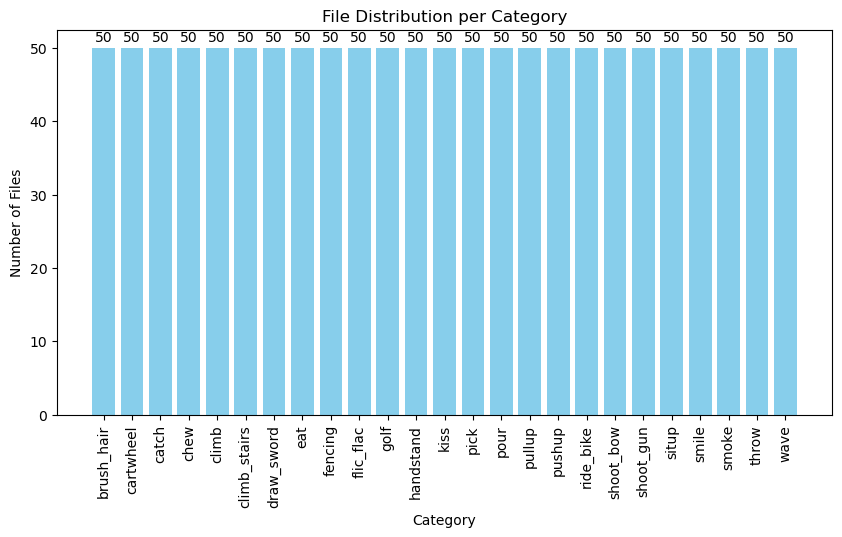

In [7]:

categories = []
folder_counts = []

for c in classes:
    folder_path = os.path.join(DATASET_PATH, c)
    total_files = len([f for f in os.listdir(folder_path) if not f.startswith('.')])  # Ignore hidden files

    categories.append(c)
    folder_counts.append(total_files)

# Sort categories by file count
sorted_categories, sorted_counts = zip(*sorted(zip(categories, folder_counts)))

plt.figure(figsize=(10, 5))
plt.bar(sorted_categories, sorted_counts, color='skyblue')
plt.xlabel("Category")
plt.ylabel("Number of Files")
plt.title("File Distribution per Category")
plt.xticks(rotation=90)

# Add numbers on top of bars
for i, count in enumerate(sorted_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


In [8]:
subfolders = []
file_counts = []
class_name = []

for c in classes:
    folder_path = os.path.join(DATASET_PATH, c)

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            subfolder_files = len(os.listdir(subfolder_path))
            #print(f"{c}/{subfolder}: {subfolder_files}")

            # Store for plotting
            subfolders.append(f"{c}/{subfolder}")
            file_counts.append(subfolder_files)
            class_name.append(c)


df = pd.DataFrame({"Class": class_name, "File Count": file_counts})


/var/folders/9s/md4xnzf949vc59xqd_slzxy00000gn/T/ipykernel_16805/1305964851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="File Count", data=df, palette="Set2")


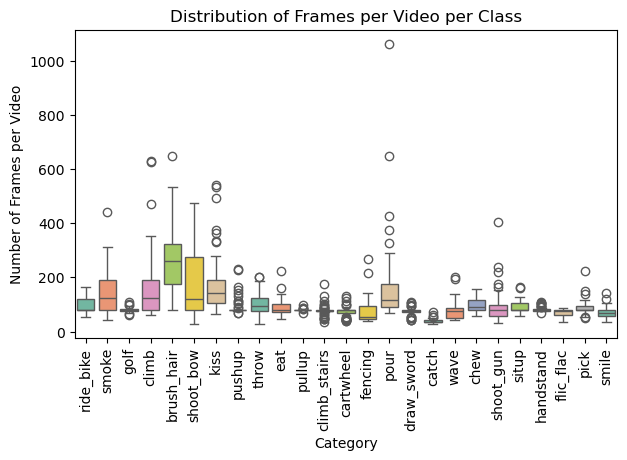

In [9]:
# Plot box plot
plt.figure(figsize=(7, 4))
sns.boxplot(x="Class", y="File Count", data=df, palette="Set2")

plt.xlabel("Category")
plt.ylabel("Number of Frames per Video")
plt.title("Distribution of Frames per Video per Class")
plt.xticks(rotation=90)
plt.show()


/var/folders/9s/md4xnzf949vc59xqd_slzxy00000gn/T/ipykernel_16805/137124369.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Class", y="File Count", data=df, jitter=True, alpha=0.7, palette="Set2")


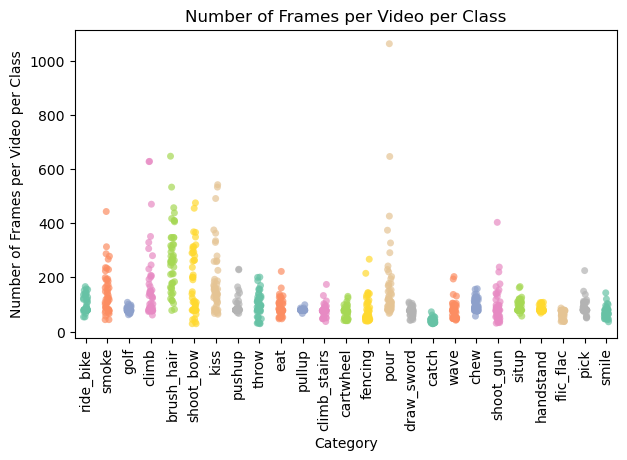

In [10]:
plt.figure(figsize=(7, 4))
sns.stripplot(x="Class", y="File Count", data=df, jitter=True, alpha=0.7, palette="Set2")

plt.xlabel("Category")
plt.ylabel("Number of Frames per Video per Class")
plt.title("Number of Frames per Video per Class")
plt.xticks(rotation=90)
plt.show()


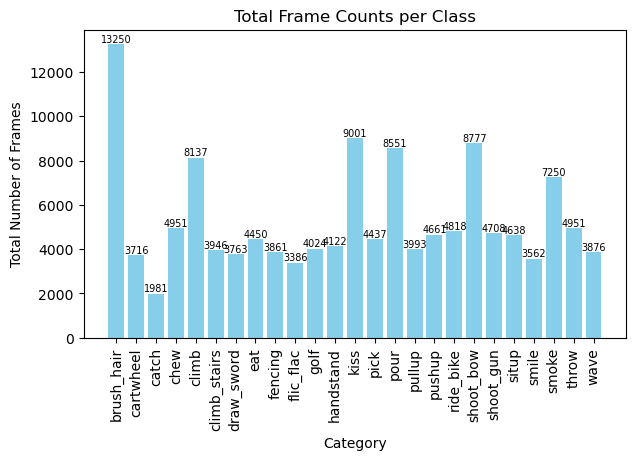

In [11]:
import matplotlib.pyplot as plt

# Aggregate total files per class
class_totals = {c: 0 for c in set(class_name)}
for c, count in zip(class_name, file_counts):
    class_totals[c] += count

# Sort alphabetically by class name
sorted_classes = sorted(class_totals.keys())
sorted_counts = [class_totals[c] for c in sorted_classes]

plt.figure(figsize=(7, 4))
bars = plt.bar(sorted_classes, sorted_counts, color="skyblue")

# Add text labels on top of each bar
for bar, count in zip(bars, sorted_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha="center", va="bottom", fontsize=7)

plt.xlabel("Category")
plt.ylabel("Total Number of Frames")
plt.title("Total Frame Counts per Class")
plt.xticks(rotation=90)
plt.show()


### Split into train/test

In [ ]:
dataset[0][1]

In [ ]:
all_updated_metadata[0]

In [ ]:
'''
def load_sampled_frames(frame_dir, frame_rate=8):
    """
    Load every [frame_rate]-th frame from a directory and apply transformations.
    """
    frame_files = sorted(os.listdir(frame_dir))  # Ensure frames are in order
    sampled_frames = []
    frame_metadata = []

    for i in range(0, len(frame_files), frame_rate):
        frame_path = os.path.join(frame_dir, frame_files[i])
        frame = Image.open(frame_path).convert("RGB")  # Convert to RGB
        frame = transform(frame)  # Apply transformations
        sampled_frames.append(frame)
        frame_metadata.append({'index': i, 'used_in_clip': False, 'file_path': frame_path})  # Add file path to metadata

    return sampled_frames, frame_metadata  # List of torch tensors


def create_clips(frames, frame_metadata, clip_size=8):
    """
    Given a list of sampled frames, create multiple [clip_size]-frame clips.
    """
    clips = []
    clip_indices = []
    updated_metadata = []
    if len(frames) < clip_size:
        return clips, updated_metadata, clip_indices  # Not enough frames to create a clip
    
    for i in range(0, len(frames) - clip_size + 1, clip_size):  # Sliding window
        clip = torch.stack(frames[i:i + clip_size])  # Stack into (clip_size, 3, 224, 224)
        clips.append(clip)
        clip_indices.append([frame_metadata[j]['index'] for j in range(i, i + clip_size)])

        clip_metadata = [frame_metadata[j]['file_path'] for j in range(i, i + clip_size)]  # Collect file paths
        updated_metadata.append(clip_metadata)

        # Mark frames as used in a clip
        for j in range(i, i + clip_size):
            frame_metadata[j]['used_in_clip'] = True

    return clips, updated_metadata, clip_indices


# Main processing loop
dataset = []
all_updated_metadata = []

for category, instances in tqdm(train_sources.items()):
    category_path = os.path.join(DATASET_PATH, category)

    for instance in instances:
        instance_path = os.path.join(category_path, instance)
        if not os.path.isdir(instance_path):
            continue  # Skip non-directory files

        # Load sampled frames
        frames, frame_metadata = load_sampled_frames(instance_path)

        # Create 8-frame clips
        clips, updated_metadata, clip_indices = create_clips(frames, frame_metadata)

        for i, clip in enumerate(clips):
            dataset.append((clip, CATEGORY_INDEX[category]))  # Store (clip, label)
            all_updated_metadata.append(updated_metadata[i])  # Append the list of file paths for each clip
'''

In [12]:
len(all_updated_metadata)

NameError: name 'all_updated_metadata' is not defined

In [ ]:
all_updated_metadata

In [ ]:
prefix = './HMDB_simp/brush_hair'

# Find items that start with the prefix
matching_items = []
for metadata_list in all_updated_metadata:
    # Filter the items in the inner list that start with the prefix
    matching_items.extend([item for item in metadata_list if item.startswith(prefix)])

matching_items

In [ ]:
prefix = './HMDB_simp/brush_hair/'

unique_folders = set(os.path.dirname(item) for item in matching_items if item.startswith(prefix))

# Count the number of unique folder paths
unique_folder_count = len(unique_folders)

In [ ]:
folder_names = [f"{path.split('/')[2]}/{path.split('/')[3]}" for sublist in all_updated_metadata for path in sublist]

# Count occurrences of each folder
folder_counts = Counter(folder_names)

# Print the count for all folders
#for folder, count in folder_counts.items():
#    print(f"Folder '{folder}' appears {count} times")

for folder in sorted(folder_counts.keys()):
    print(f"Folder '{folder}' appears {folder_counts[folder]} times")

In [13]:
# Split source folders into train & val
train_sources, val_sources = split_sources(DATASET_PATH)

In [14]:
# Process train and val sets separately
train_dataset, train_metadata = process_dataset(DATASET_PATH, train_sources)
val_dataset, val_metadata = process_dataset(DATASET_PATH, val_sources)

dataset_size = len(train_dataset) + len(val_dataset)

print(f"Total clips: {dataset_size}, Train: {len(train_dataset)}, Val: {len(val_dataset)}")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Total clips: 1627, Train: 1292, Val: 335


In [15]:
(train_dataset[0][0]).shape, train_dataset[0][1]

(torch.Size([8, 3, 224, 224]), 17)

In [16]:
train_metadata[0]

['./HMDB_simp/ride_bike/7FDA6503/0001.jpg',
 './HMDB_simp/ride_bike/7FDA6503/0009.jpg',
 './HMDB_simp/ride_bike/7FDA6503/0017.jpg',
 './HMDB_simp/ride_bike/7FDA6503/0025.jpg',
 './HMDB_simp/ride_bike/7FDA6503/0033.jpg',
 './HMDB_simp/ride_bike/7FDA6503/0041.jpg',
 './HMDB_simp/ride_bike/7FDA6503/0049.jpg',
 './HMDB_simp/ride_bike/7FDA6503/0057.jpg']

In [17]:
print(f"train dataset: {len(train_dataset), type(train_dataset)}")
print(f"val dataset: {len(val_dataset), type(val_dataset)}")

train dataset: (1292, <class 'list'>)
val dataset: (335, <class 'list'>)


In [ ]:
len(val_dataset[0]),type(val_dataset[0])

In [ ]:
train_dataset

In [ ]:
(train_dataset[315][0]).shape, (val_dataset[315][0]).shape

In [18]:
from collections import Counter

def count_classes(dataset):
    """
    Counts the occurrences of each class label in a dataset and prints 
    the counts in ascending order of class labels.
    """
    class_counts = Counter(label for _, label in dataset)
    sorted_class_counts = dict(sorted(class_counts.items()))

    for class_label, count in sorted_class_counts.items():
        print(f"Class {class_label}: {count} clips of 8")

    return sorted_class_counts


In [19]:
print("train_dataset")
count_classes(train_dataset); 
print("")
print("val_dataset")
count_classes(val_dataset);

train_dataset
Class 0: 155 clips of 8
Class 1: 33 clips of 8
Class 2: 2 clips of 8
Class 3: 47 clips of 8
Class 4: 93 clips of 8
Class 5: 35 clips of 8
Class 6: 35 clips of 8
Class 7: 36 clips of 8
Class 8: 29 clips of 8
Class 9: 30 clips of 8
Class 10: 39 clips of 8
Class 11: 40 clips of 8
Class 12: 102 clips of 8
Class 13: 39 clips of 8
Class 14: 81 clips of 8
Class 15: 39 clips of 8
Class 16: 45 clips of 8
Class 17: 46 clips of 8
Class 18: 95 clips of 8
Class 19: 45 clips of 8
Class 20: 43 clips of 8
Class 21: 29 clips of 8
Class 22: 79 clips of 8
Class 23: 45 clips of 8
Class 24: 30 clips of 8

val_dataset
Class 0: 33 clips of 8
Class 1: 8 clips of 8
Class 3: 13 clips of 8
Class 4: 18 clips of 8
Class 5: 10 clips of 8
Class 6: 8 clips of 8
Class 7: 16 clips of 8
Class 8: 6 clips of 8
Class 9: 10 clips of 8
Class 10: 11 clips of 8
Class 11: 10 clips of 8
Class 12: 22 clips of 8
Class 13: 11 clips of 8
Class 14: 31 clips of 8
Class 15: 11 clips of 8
Class 16: 13 clips of 8
Class 17: 

# Train

## TimeSFormer

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForVideoClassification

extractor = AutoFeatureExtractor.from_pretrained("facebook/timesformer-base-finetuned-k400")
model = AutoModelForVideoClassification.from_pretrained(
    "facebook/timesformer-base-finetuned-k400",
    num_labels=len(CATEGORY_INDEX),  # Adjust for our dataset
    ignore_mismatched_sizes=True,
)

# Send model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model on: {device}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import evaluate
import numpy as np
from transformers import AutoFeatureExtractor, AutoModelForVideoClassification, TrainingArguments, Trainer

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
top5_metric = torchmetrics.classification.Accuracy(top_k=5, task="multiclass", num_classes=len(CATEGORY_INDEX)).to(device)

# Compute Metrics Function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.tensor(logits).argmax(dim=1)

    # Compute Accuracy
    top1_acc = accuracy_metric.compute(predictions=predictions.numpy(), references=labels)["accuracy"]

    # Compute Top-5 Accuracy
    top5_acc = top5_metric(torch.tensor(logits).to(device), torch.tensor(labels).to(device)).item()

    # Compute F1-score (macro)
    f1 = f1_metric.compute(predictions=predictions.numpy(), references=labels, average="macro")["f1"]

    return {
        "accuracy": top1_acc,
        "top-5 accuracy": top5_acc,
        "f1-score": f1
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./timesformer_output",  # Save checkpoints
    evaluation_strategy="epoch",  # Evaluate after every epoch
    save_strategy="epoch",  # Save model after each epoch
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",  # TensorBoard logs
    logging_steps=10,
    save_total_limit=2,  # Keep only last 2 checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False
)

data_collator = VideoDataCollator()
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=extractor,  # Feature extractor
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# Train Model
trainer.train()